# Chapter 11: Dense Vector Representations
Training embeddings: A Toy Implementation of CBOW

Adapted from _Efficient estimation of word representations in vector space_ by Mikolov et al., 2013.

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Modules

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import regex as re
from collections import Counter
import collections
from math import log
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

## Parameters

The embedding size and context size

In [2]:
# embedding_dim = 50
w_size = 2
c_size = w_size * 2 + 1

## Corpus Files

We read the files and we store the corpus in a string

In [3]:
PATH = '../datasets/'

In [4]:
CORPUS = 'HOMER'  # 'DICKENS'

In [5]:
if CORPUS == 'DICKENS':
    folder = PATH + 'dickens/'
elif CORPUS == 'HOMER':
    folder = PATH + 'classics/'

In [6]:
def get_files(dir, suffix):
    """
    Returns all the files in a folder ending with suffix
    :param dir:
    :param suffix:
    :return: the list of file names
    """
    files = []
    for file in os.listdir(dir):
        if file.endswith(suffix):
            files.append(file)
    return files

In [7]:
if CORPUS == 'DICKENS':
    files = get_files(folder, 'txt')
elif CORPUS == 'HOMER':
    files = ['iliad.txt', 'odyssey.txt']
files

['iliad.txt', 'odyssey.txt']

In [8]:
files = [folder + file for file in files]
files

['../datasets/classics/iliad.txt', '../datasets/classics/odyssey.txt']

In [9]:
text = ''
for file in files:
    with open(file, encoding='utf8') as f:
        text += ' ' + f.read().strip()

In [10]:
text[:100]

' BOOK I\n\nSing, O goddess, the anger of Achilles son of Peleus, that brought\ncountless ills upon the '

## Processing the Corpus

We set all the text in lowercase

In [11]:
text = text.lower()
words = re.findall(r'\p{L}+', text)
words[:5]

['book', 'i', 'sing', 'o', 'goddess']

In [12]:
vocab = sorted(list(set(words)))
vocab[:10]

['a',
 'abantes',
 'abarbarea',
 'abas',
 'abate',
 'abated',
 'abetting',
 'abhorred',
 'abians',
 'abide']

In [13]:
vocab_size = len(vocab)
vocab_size

9768

In [14]:
idx2word = dict(enumerate(vocab))
word2idx = {v: k for k, v in idx2word.items()}
# word2idx

In [15]:
words_idx = [word2idx[word] for word in words]

In [16]:
def create_Xy(words):
    (X, y) = ([], [])
    c_size = 2 * w_size + 1
    for i in range(len(words) - c_size + 1):
        X.append(words[i: i + w_size] +
                 words[i + w_size + 1: i + c_size])
        y.append(words[i + w_size])
    return X, y

In [17]:
X, y = create_Xy(words)

In [18]:
X[2:5]

[['sing', 'o', 'the', 'anger'],
 ['o', 'goddess', 'anger', 'of'],
 ['goddess', 'the', 'of', 'achilles']]

In [19]:
y[2:5]

['goddess', 'the', 'anger']

In [20]:
X, y = create_Xy(words_idx)

In [21]:
X = torch.LongTensor(X)
X.size()

torch.Size([271502, 4])

In [22]:
X[2:5]

tensor([[7663, 5691, 8548,  358],
        [5691, 3697,  358, 5735],
        [3697, 8548, 5735,   67]])

In [23]:
y = torch.LongTensor(y)

In [24]:
y[2:5]

tensor([3697, 8548,  358])

## Embeddings

In [25]:
embedding_dim = 5

In [26]:
embedding = nn.Embedding(vocab_size, embedding_dim)
embedding

Embedding(9768, 5)

In [27]:
embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.1737,  0.3771,  1.1798,  0.2774,  0.3765],
                      [ 1.7672,  0.0765, -0.0130, -1.4449, -0.6143],
                      [-0.0624, -1.4087,  0.1338, -1.2423, -0.1470],
                      ...,
                      [ 1.4250,  0.8897, -0.4126, -0.9992, -0.0307],
                      [-0.3522,  2.3213, -0.9081,  1.3450,  1.7535],
                      [-1.1921,  0.8879,  1.5717,  0.0358, -1.7487]]))])

In [28]:
embedding.weight[:5]

tensor([[ 0.1737,  0.3771,  1.1798,  0.2774,  0.3765],
        [ 1.7672,  0.0765, -0.0130, -1.4449, -0.6143],
        [-0.0624, -1.4087,  0.1338, -1.2423, -0.1470],
        [-0.5666,  1.0878, -0.1373, -1.4274,  1.4166],
        [ 0.5608, -0.2141, -0.1571,  1.1176,  1.1655]],
       grad_fn=<SliceBackward0>)

In [29]:
embedding(torch.LongTensor([3, 2, 1]))

tensor([[-0.5666,  1.0878, -0.1373, -1.4274,  1.4166],
        [-0.0624, -1.4087,  0.1338, -1.2423, -0.1470],
        [ 1.7672,  0.0765, -0.0130, -1.4449, -0.6143]],
       grad_fn=<EmbeddingBackward0>)

In [30]:
embedding(X[2:5])

tensor([[[ 0.8082,  0.3516,  0.3602,  1.0301, -2.7528],
         [ 0.0663,  0.0721,  0.1768, -1.0101, -0.7445],
         [ 0.4754,  0.9378,  0.5265, -1.4136,  2.6541],
         [ 0.0164, -0.4261, -0.9703,  0.1743,  1.3088]],

        [[ 0.0663,  0.0721,  0.1768, -1.0101, -0.7445],
         [-0.3477, -0.1779, -0.3432, -0.7665, -0.6078],
         [ 0.0164, -0.4261, -0.9703,  0.1743,  1.3088],
         [-0.0621,  0.2374, -0.0913,  0.4350, -0.9314]],

        [[-0.3477, -0.1779, -0.3432, -0.7665, -0.6078],
         [ 0.4754,  0.9378,  0.5265, -1.4136,  2.6541],
         [-0.0621,  0.2374, -0.0913,  0.4350, -0.9314],
         [-2.3518,  1.5487,  0.3069, -0.1063, -0.3414]]],
       grad_fn=<EmbeddingBackward0>)

In [31]:
embedding(X[2:5]).size()

torch.Size([3, 4, 5])

In [32]:
embedding(X[2:5]).mean(dim=1)

tensor([[ 0.3416,  0.2338,  0.0233, -0.3048,  0.1164],
        [-0.0818, -0.0736, -0.3070, -0.2918, -0.2437],
        [-0.5715,  0.6365,  0.0997, -0.4628,  0.1934]],
       grad_fn=<MeanBackward1>)

## Embedding Bags

In [33]:
embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

In [34]:
embedding_bag = nn.EmbeddingBag.from_pretrained(
    embedding.state_dict()['weight'])

In [35]:
embedding_bag(X[2:5])

tensor([[ 0.3416,  0.2338,  0.0233, -0.3048,  0.1164],
        [-0.0818, -0.0736, -0.3070, -0.2918, -0.2437],
        [-0.5715,  0.6365,  0.0997, -0.4628,  0.1934]])

## Cosine similarity

A few test words

In [36]:
if CORPUS == 'HOMER':
    test_words = ['he', 'she', 'ulysses', 'penelope', 'achaeans', 'trojans',
                  'achilles', 'sea', 'helen', 'ship', 'her', 'fight']
elif CORPUS == 'DICKENS':
    test_words = ['he', 'she', 'her', 'sea', 'ship',
                  'fight', 'table', 'london', 'monday']

In [37]:
def most_sim_vecs(u, E, N=10):
    cos = nn.CosineSimilarity()
    cos_sim = cos(u.unsqueeze(dim=0), E)
    sorted_vectors = sorted(range(len(cos_sim)),
                            key=lambda k: -cos_sim[k])
    return sorted_vectors[1:N + 1]

In [38]:
most_sim_vecs(embedding_bag.weight[0], embedding_bag.weight)

[9319, 44, 1033, 7482, 2116, 8764, 6223, 6021, 4002, 6152]

In [39]:
def sim_test_words(test_words, word2idx, model, N=10):
    most_sim_words = {}
    with torch.no_grad():
        E = model[0].weight
        for w in test_words:
            most_sim_words[w] = most_sim_vecs(E[word2idx[w]], E, N)
            most_sim_words[w] = list(map(idx2word.get, most_sim_words[w]))
            print(w, most_sim_words[w])

## The Architecture

In [40]:
embedding_dim = 50

In [41]:
model = nn.Sequential(
    nn.EmbeddingBag(vocab_size, embedding_dim),
    nn.Linear(embedding_dim, vocab_size))
model

Sequential(
  (0): EmbeddingBag(9768, 50, mode='mean')
  (1): Linear(in_features=50, out_features=9768, bias=True)
)

In [42]:
model(X[2:7])

tensor([[ 0.0733, -0.0977, -0.2934,  ..., -0.0106, -0.3453, -0.2399],
        [ 0.2231, -0.0435,  0.0814,  ..., -0.1339,  0.0553, -0.2110],
        [ 0.0069, -0.1303,  0.2014,  ...,  0.2497,  0.0264, -0.1335],
        [-0.1215, -0.2165, -0.2204,  ...,  0.1771, -0.2054,  0.0771],
        [ 0.0499, -0.1266,  0.1823,  ...,  0.1859,  0.3648, -0.1997]],
       grad_fn=<AddmmBackward0>)

In [43]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 1.0041, -0.1654,  1.1613,  ..., -0.6438, -0.2542, -1.3030],
                      [ 0.4397, -1.1794, -0.5466,  ...,  0.1927,  0.8846, -0.6694],
                      [ 0.1327,  1.7947,  1.2247,  ..., -1.8574,  1.7945,  0.8028],
                      ...,
                      [-1.0371,  0.4998,  1.6418,  ...,  0.4735, -0.3189,  0.7209],
                      [-0.0464,  1.0293,  1.0676,  ...,  0.3349, -1.7740,  1.2176],
                      [-1.0461,  0.6328,  1.9822,  ...,  1.4004,  1.0726,  0.4726]])),
             ('1.weight',
              tensor([[-0.0922, -0.0593,  0.1332,  ...,  0.0762,  0.0387, -0.0130],
                      [ 0.0860, -0.0090, -0.0633,  ...,  0.0441, -0.0889, -0.0198],
                      [-0.0755,  0.0038,  0.0648,  ...,  0.1200,  0.0509,  0.0166],
                      ...,
                      [ 0.0738,  0.1004, -0.0985,  ..., -0.0446, -0.1305,  0.0357],
                      [-0.0264, -0.1265,  0.0685,  

In [44]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.NAdam(model.parameters(), lr=0.025)

In [45]:
BATCH_SIZE = 1024

In [46]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1)

In [47]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [48]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training the Model

Train validation loop to be able to call it

In [49]:
def train_val_loop():
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    model.train()
    for epoch in tqdm(range(10)):
        train_loss = 0
        train_acc = 0
        batch_cnt = 0
        for X_batch, y_batch in train_dataloader:
            y_batch_pred = model(X_batch)
            loss = loss_fn(y_batch_pred, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(y_batch ==
                                   torch.argmax(y_batch_pred, dim=-1))/BATCH_SIZE
            batch_cnt += 1
        train_acc /= batch_cnt
        train_acc_history += [train_acc]
        train_loss /= batch_cnt
        train_loss_history += [train_loss]

        model.eval()
        with torch.no_grad():
            val_acc = 0
            val_loss = 0
            val_batch_cnt = 0
            for X_batch, y_batch in val_dataloader:
                y_batch_pred = model(X_batch)
                loss = loss_fn(y_batch_pred, y_batch)
                val_loss += loss.item()
                val_acc += torch.sum(y_batch ==
                                     torch.argmax(y_batch_pred, dim=-1))/BATCH_SIZE
                val_batch_cnt += 1
            val_acc /= val_batch_cnt
            val_acc_history += [val_acc]
            val_loss /= val_batch_cnt
            val_loss_history += [val_loss]
            sim_test_words(test_words, word2idx, model)
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

No validation

In [50]:
def train_loop():
    train_loss_history = []
    train_acc_history = []
    model.train()
    for epoch in tqdm(range(5)):
        train_loss = 0
        train_acc = 0
        batch_cnt = 0
        for X_batch, y_batch in dataloader:
            y_batch_pred = model(X_batch)
            loss = loss_fn(y_batch_pred, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(y_batch ==
                                   torch.argmax(y_batch_pred, dim=-1))/BATCH_SIZE
            batch_cnt += 1
        train_acc /= batch_cnt
        train_acc_history += [train_acc]
        train_loss /= batch_cnt
        train_loss_history += [train_loss]

        model.eval()
        with torch.no_grad():
            sim_test_words(test_words, word2idx, model)
    return train_loss_history, train_acc_history

`VAL` should be set to true. The other choice is to study the influence of having a validation set on a small corpus

In [51]:
VAL = True
if VAL:
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_val_loop()
else:
    train_loss_history, train_acc_history = train_loop()

  0%|          | 0/10 [00:00<?, ?it/s]

he ['she', 'they', 'achilles', 'piraeus', 'penelope', 'enemies', 'orestes', 'ulysses', 'enveloped', 'fatuous']
she ['he', 'decline', 'achilles', 'liar', 'they', 'i', 'teucer', 'enemies', 'billet', 'thump']
ulysses ['telemachus', 'antinous', 'achilles', 'nestor', 'blazing', 'bitterness', 'diomed', 'hector', 'amphiclus', 'diplomacy']
penelope ['fulness', 'despairingly', 'eumaeus', 'achilles', 'danger', 'deiochus', 'assuredly', 'he', 'prison', 'eurylochus']
achaeans ['others', 'swineherd', 'sun', 'pouncing', 'argives', 'plain', 'neighbours', 'wrecks', 'trojans', 'onslaught']
trojans ['rear', 'mountains', 'breathes', 'finest', 'nipple', 'muscles', 'girl', 'town', 'day', 'tread']
achilles ['he', 'ulysses', 'she', 'neptune', 'polydamas', 'neoptolemus', 'uncivil', 'hyrtacus', 'penelope', 'tecton']
sea ['health', 'nymph', 'pylos', 'town', 'spying', 'meat', 'asterius', 'world', 'bier', 'rattle']
helen ['rage', 'grief', 'neleus', 'thoon', 'rouse', 'judgement', 'enough', 'naughtiness', 'relieved'

 10%|█         | 1/10 [00:11<01:41, 11.24s/it]

her ['pylos', 'loitering', 'afford', 'letters', 'his', 'poles', 'sadly', 'pherae', 'rough', 'my']
fight ['prevaricate', 'respecting', 'lesbians', 'dangerous', 'wolves', 'facile', 'reckon', 'expected', 'ortilochus', 'apaesus']
he ['she', 'achilles', 'they', 'enveloped', 'fatuous', 'tecton', 'we', 'patroclous', 'orestes', 'i']
she ['he', 'they', 'juno', 'oeeneus', 'i', 'achilles', 'afford', 'eupeithes', 'euryclea', 'nausicaa']
ulysses ['telemachus', 'antinous', 'achilles', 'nestor', 'diomed', 'eurymachus', 'hector', 'amphiclus', 'diplomacy', 'telamon']
penelope ['telemachus', 'despairingly', 'arete', 'achilles', 'eurylochus', 'eumaeus', 'ulysses', 'fulness', 'hades', 'prison']
achaeans ['argives', 'trojans', 'others', 'swineherd', 'danaans', 'suitors', 'precincts', 'phereclus', 'pair', 'forelands']
trojans ['achaeans', 'argives', 'mountains', 'nipple', 'evenings', 'cornice', 'plain', 'finest', 'phereclus', 'ice']
achilles ['ulysses', 'pylaemenes', 'patroclus', 'he', 'sarpedon', 'polydama

 20%|██        | 2/10 [00:22<01:31, 11.47s/it]

fight ['prevaricate', 'reckon', 'orchard', 'offices', 'array', 'keener', 'usher', 'athletic', 'doughty', 'quail']
he ['she', 'achilles', 'they', 'we', 'violet', 'i', 'erylaus', 'polydamas', 'oeeneus', 'eurylochus']
she ['he', 'juno', 'they', 'oeeneus', 'i', 'nausicaa', 'dreamland', 'achilles', 'minerva', 'we']
ulysses ['telemachus', 'achilles', 'antinous', 'nestor', 'eurymachus', 'amphinomus', 'hector', 'polybus', 'amphiclus', 'penelope']
penelope ['juno', 'arete', 'telemachus', 'helen', 'ulysses', 'prison', 'hades', 'sirs', 'achilles', 'oracle']
achaeans ['argives', 'danaans', 'trojans', 'others', 'phereclus', 'swineherd', 'precincts', 'suitors', 'gods', 'pair']
trojans ['achaeans', 'argives', 'danaans', 'mountains', 'phereclus', 'nipple', 'test', 'evenings', 'ice', 'myrmidons']
achilles ['pylaemenes', 'ulysses', 'he', 'patroclus', 'sarpedon', 'dione', 'polydamas', 'agamemnon', 'amphinomus', 'meges']
sea ['trench', 'foe', 'watered', 'rhytium', 'spying', 'gloriously', 'danger', 'nymph'

 30%|███       | 3/10 [00:34<01:19, 11.36s/it]

fight ['usher', 'orchard', 'array', 'prevaricate', 'offices', 'prosper', 'ajaxes', 'keener', 'doughty', 'foolishly']
he ['she', 'they', 'achilles', 'we', 'polydamas', 'megapenthes', 'i', 'unprotected', 'butt', 'hector']
she ['he', 'they', 'oeeneus', 'juno', 'i', 'nausicaa', 'privately', 'dreamland', 'minerva', 'we']
ulysses ['telemachus', 'achilles', 'antinous', 'eurymachus', 'nestor', 'amphinomus', 'hector', 'amphiclus', 'polybus', 'diomed']
penelope ['juno', 'dreamland', 'telemachus', 'circe', 'arete', 'ulysses', 'minerva', 'euryclea', 'hades', 'yes']
achaeans ['danaans', 'argives', 'trojans', 'others', 'phereclus', 'precincts', 'swineherd', 'gods', 'suitors', 'lycians']
trojans ['achaeans', 'argives', 'danaans', 'mountains', 'hosts', 'phereclus', 'test', 'phoceans', 'hoggets', 'myrmidons']
achilles ['ulysses', 'pylaemenes', 'patroclus', 'he', 'hector', 'dolopion', 'polydamas', 'sarpedon', 'agamemnon', 'tlepolemus']
sea ['rhytium', 'trench', 'foe', 'watered', 'muscles', 'nymph', 'noo

 40%|████      | 4/10 [00:45<01:08, 11.39s/it]

her ['capys', 'his', 'epicaste', 'opoeis', 'your', 'my', 'charops', 'him', 'noticing', 'sparkling']
fight ['prosper', 'offices', 'suck', 'orchard', 'baring', 'perish', 'cause', 'doughty', 'foolishly', 'prevaricate']
he ['she', 'they', 'achilles', 'we', 'erylaus', 'i', 'unprotected', 'raven', 'prison', 'ulysses']
she ['he', 'juno', 'they', 'minerva', 'oeeneus', 'i', 'privately', 'nausicaa', 'complexion', 'dreamland']
ulysses ['telemachus', 'achilles', 'antinous', 'eurymachus', 'polybus', 'peleus', 'hector', 'mynes', 'nestor', 'amphinomus']
penelope ['juno', 'telemachus', 'dreamland', 'circe', 'arete', 'phoenix', 'minerva', 'euryclea', 'achilles', 'awoke']
achaeans ['danaans', 'argives', 'trojans', 'others', 'precincts', 'swineherd', 'phereclus', 'gods', 'suitors', 'phaeacians']
trojans ['argives', 'achaeans', 'danaans', 'hosts', 'mountains', 'myrmidons', 'phereclus', 'sintians', 'test', 'hoggets']
achilles ['ulysses', 'pylaemenes', 'patroclus', 'sarpedon', 'hector', 'he', 'agamemnon', '

 50%|█████     | 5/10 [00:56<00:56, 11.36s/it]

fight ['prosper', 'baring', 'offices', 'suck', 'cause', 'remain', 'mare', 'career', 'ointments', 'sacred']
he ['she', 'achilles', 'they', 'we', 'i', 'unprotected', 'erylaus', 'prison', 'polydamas', 'raven']
she ['he', 'they', 'juno', 'minerva', 'privately', 'i', 'dreamland', 'we', 'oeeneus', 'nausicaa']
ulysses ['telemachus', 'achilles', 'eurymachus', 'antinous', 'peleus', 'polybus', 'mynes', 'alcinous', 'menelaus', 'hector']
penelope ['juno', 'circe', 'arete', 'dreamland', 'telemachus', 'phoenix', 'euryclea', 'minerva', 'seer', 'achilles']
achaeans ['danaans', 'argives', 'trojans', 'others', 'precincts', 'gods', 'phereclus', 'lycians', 'swineherd', 'captains']
trojans ['argives', 'achaeans', 'danaans', 'hosts', 'myrmidons', 'mountains', 'sintians', 'hoggets', 'phereclus', 'phoceans']
achilles ['ulysses', 'he', 'hector', 'patroclus', 'pylaemenes', 'agamemnon', 'tlepolemus', 'sarpedon', 'dolopion', 'polydamas']
sea ['rhytium', 'trench', 'seas', 'noontide', 'ditch', 'town', 'bearded', 'a

 60%|██████    | 6/10 [01:08<00:45, 11.36s/it]

her ['sparkling', 'capys', 'him', 'his', 'charops', 'epicaste', 'opoeis', 'my', 'your', 'pherae']
fight ['offices', 'baring', 'prosper', 'overreach', 'suck', 'ointments', 'help', 'consciences', 'vultures', 'congratulate']
he ['she', 'they', 'achilles', 'i', 'we', 'erylaus', 'ulysses', 'raven', 'unprotected', 'prison']
she ['he', 'they', 'i', 'juno', 'minerva', 'privately', 'ulysses', 'dreamland', 'oeeneus', 'we']
ulysses ['telemachus', 'achilles', 'antinous', 'eurymachus', 'mynes', 'polybus', 'mars', 'she', 'diomed', 'juno']
penelope ['juno', 'circe', 'seer', 'arete', 'telemachus', 'dreamland', 'attempt', 'euryclea', 'phoenix', 'repay']
achaeans ['danaans', 'argives', 'trojans', 'others', 'gods', 'precincts', 'suitors', 'lycians', 'hoggets', 'captains']
trojans ['achaeans', 'argives', 'danaans', 'hosts', 'myrmidons', 'sintians', 'hoggets', 'mountains', 'others', 'gods']
achilles ['ulysses', 'patroclus', 'he', 'hector', 'sarpedon', 'agamemnon', 'tlepolemus', 'polydamas', 'pylaemenes', '

 70%|███████   | 7/10 [01:19<00:34, 11.34s/it]

fight ['baring', 'prosper', 'overreach', 'offices', 'vultures', 'ointments', 'remain', 'seemly', 'consciences', 'suck']
he ['she', 'they', 'achilles', 'we', 'i', 'ulysses', 'erylaus', 'raven', 'harden', 'unprotected']
she ['he', 'they', 'juno', 'i', 'minerva', 'privately', 'ulysses', 'dreamland', 'nausicaa', 'we']
ulysses ['telemachus', 'achilles', 'antinous', 'eurymachus', 'mynes', 'peleus', 'menelaus', 'polybus', 'hector', 'nestor']
penelope ['juno', 'circe', 'phoenix', 'euryclea', 'arete', 'seer', 'neptune', 'dreamland', 'telemachus', 'minerva']
achaeans ['danaans', 'argives', 'trojans', 'gods', 'others', 'precincts', 'lycians', 'suitors', 'captains', 'hoggets']
trojans ['achaeans', 'argives', 'danaans', 'myrmidons', 'hosts', 'sintians', 'mountains', 'hoggets', 'gods', 'phereclus']
achilles ['ulysses', 'hector', 'patroclus', 'tlepolemus', 'he', 'agamemnon', 'coon', 'pylaemenes', 'echeclus', 'nestor']
sea ['noontide', 'trench', 'rhytium', 'seas', 'muscles', 'daintiest', 'town', 'seas

 80%|████████  | 8/10 [01:30<00:22, 11.27s/it]

fight ['shrink', 'baring', 'remain', 'mare', 'offices', 'ointments', 'vultures', 'consciences', 'suck', 'prosper']
he ['she', 'they', 'achilles', 'we', 'i', 'erylaus', 'raven', 'harden', 'envoys', 'finer']
she ['he', 'they', 'i', 'privately', 'juno', 'minerva', 'dreamland', 'complexion', 'oeeneus', 'we']
ulysses ['telemachus', 'achilles', 'eurymachus', 'antinous', 'peleus', 'mynes', 'polybus', 'ochesius', 'hector', 'mars']
penelope ['juno', 'seer', 'circe', 'arete', 'neptune', 'telemachus', 'dreamland', 'phoenix', 'attempt', 'achilles']
achaeans ['danaans', 'argives', 'trojans', 'others', 'gods', 'precincts', 'lycians', 'suitors', 'captains', 'hoggets']
trojans ['argives', 'achaeans', 'danaans', 'myrmidons', 'hosts', 'sintians', 'hoggets', 'gods', 'midriff', 'sobs']
achilles ['ulysses', 'hector', 'patroclus', 'he', 'agamemnon', 'pylaemenes', 'tlepolemus', 'polydamas', 'telemachus', 'echeclus']
sea ['trench', 'rhytium', 'noontide', 'seashore', 'seas', 'ditch', 'daintiest', 'town', 'rock

 90%|█████████ | 9/10 [01:42<00:11, 11.35s/it]

fight ['ointments', 'baring', 'pursue', 'offices', 'singing', 'suck', 'impress', 'consciences', 'remain', 'fastest']
he ['she', 'achilles', 'they', 'we', 'i', 'erylaus', 'ulysses', 'raven', 'unprotected', 'ruder']
she ['he', 'they', 'minerva', 'juno', 'i', 'we', 'privately', 'complexion', 'ulysses', 'oeeneus']
ulysses ['telemachus', 'achilles', 'antinous', 'menelaus', 'mars', 'eurymachus', 'hector', 'juno', 'peleus', 'mynes']
penelope ['juno', 'seer', 'arete', 'circe', 'euryclea', 'telemachus', 'phoenix', 'neptune', 'dreamland', 'attempt']
achaeans ['danaans', 'argives', 'trojans', 'gods', 'others', 'precincts', 'lycians', 'suitors', 'hoggets', 'sintians']
trojans ['argives', 'achaeans', 'danaans', 'hosts', 'myrmidons', 'midriff', 'sintians', 'gods', 'sobs', 'hoggets']
achilles ['hector', 'patroclus', 'ulysses', 'he', 'pylaemenes', 'maris', 'agamemnon', 'tlepolemus', 'juno', 'acamas']
sea ['trench', 'noontide', 'seas', 'seashore', 'rhytium', 'ditch', 'town', 'table', 'aulis', 'rock']
h

100%|██████████| 10/10 [01:54<00:00, 11.42s/it]

her ['his', 'him', 'my', 'your', 'capys', 'azeus', 'sparkling', 'charops', 'me', 'opoeis']
fight ['ointments', 'pursue', 'consciences', 'offices', 'vultures', 'remain', 'fastest', 'singing', 'manger', 'shrink']


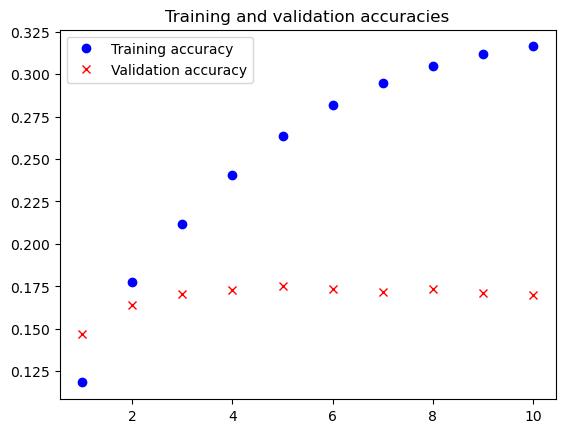

In [52]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_history) + 1)
plt.plot(epochs, train_acc_history, 'bo', label='Training accuracy')
if VAL:
    plt.plot(epochs, val_acc_history, 'rx', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()
plt.show()

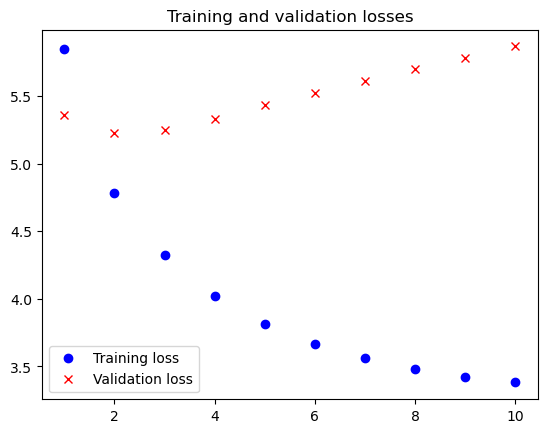

In [53]:
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, 'bo', label='Training loss')
if VAL:
    plt.plot(epochs, val_loss_history, 'rx', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

In [54]:
sim_test_words(test_words, word2idx, model, N=3)

he ['she', 'achilles', 'they']
she ['he', 'they', 'minerva']
ulysses ['telemachus', 'achilles', 'antinous']
penelope ['juno', 'seer', 'arete']
achaeans ['danaans', 'argives', 'trojans']
trojans ['argives', 'achaeans', 'danaans']
achilles ['hector', 'patroclus', 'ulysses']
sea ['trench', 'noontide', 'seas']
helen ['minerva', 'themis', 'dolius']
ship ['vessel', 'fountains', 'rope']
her ['his', 'him', 'my']
fight ['ointments', 'pursue', 'consciences']


## Model Weights

In [55]:
# torch.save(model, 'cbow_dickens')

In [56]:
model[0].weight

Parameter containing:
tensor([[ 0.5173,  1.2655,  0.7944,  ..., -0.4222,  0.1519, -1.1877],
        [-2.8581, -1.6332,  1.0740,  ..., -1.8428,  5.6901, -1.9777],
        [ 0.1722, -0.1950, -0.2896,  ..., -1.5331,  0.6784, -0.9865],
        ...,
        [-0.9434,  0.5549,  2.9032,  ..., -1.7209,  1.0306,  1.3737],
        [-1.2239, -1.1893,  1.7747,  ..., -1.3585, -1.5708, -0.4995],
        [ 2.4506, -3.1609, -0.3458,  ...,  1.7469,  2.9888, -1.9128]],
       requires_grad=True)

In [57]:
model.state_dict()['0.weight']

tensor([[ 0.5173,  1.2655,  0.7944,  ..., -0.4222,  0.1519, -1.1877],
        [-2.8581, -1.6332,  1.0740,  ..., -1.8428,  5.6901, -1.9777],
        [ 0.1722, -0.1950, -0.2896,  ..., -1.5331,  0.6784, -0.9865],
        ...,
        [-0.9434,  0.5549,  2.9032,  ..., -1.7209,  1.0306,  1.3737],
        [-1.2239, -1.1893,  1.7747,  ..., -1.3585, -1.5708, -0.4995],
        [ 2.4506, -3.1609, -0.3458,  ...,  1.7469,  2.9888, -1.9128]])

In [58]:
model[0].weight.size()

torch.Size([9768, 50])

In [59]:
import pandas as pd

df = pd.DataFrame(
    model[0].weight.detach().numpy(),
    index=[idx2word[i] for i in range(len(idx2word))])

In [60]:
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
a,0.517345,1.265482,0.794385,1.577899,-1.394573,0.317281,-1.182178,-1.193957,-0.982183,-0.685607,...,-1.555079,0.112718,-1.122664,-1.103504,1.114796,0.518942,0.828255,-0.422223,0.151884,-1.187695
abantes,-2.858094,-1.633240,1.074035,-1.460754,1.037198,0.346289,-1.343567,-0.033231,-0.031642,-0.126830,...,0.058360,2.711225,2.733832,-0.203771,3.902786,-3.544014,0.132149,-1.842802,5.690100,-1.977703
abarbarea,0.172249,-0.195018,-0.289569,0.574032,0.739325,-1.369421,1.052140,2.317798,2.275649,0.782789,...,-3.251135,-0.926940,-0.671342,-3.150924,1.130388,-1.092152,-1.728019,-1.533120,0.678406,-0.986490
abas,0.204807,0.526156,-2.186397,0.351892,-2.342386,-2.756754,-0.873891,1.983503,-1.218430,-0.964939,...,1.892505,1.908924,3.236400,-1.485702,-0.855844,0.377560,2.087806,-1.969180,1.141522,-1.564561
abate,0.827547,3.051754,2.464833,2.899755,3.393968,4.858458,-0.264149,0.592467,-2.726633,-0.883718,...,0.928480,0.618532,-2.142559,2.747660,-2.001208,1.520448,4.820977,-1.002338,-1.113353,-1.253376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zeal,-0.334891,-2.092076,1.263776,-1.406186,-2.512011,2.574392,-0.241822,2.654207,-0.001024,0.646306,...,-3.445961,1.513561,-1.365037,1.495004,0.141923,-0.813910,-2.369867,0.205204,-0.153230,-1.821516
zelea,2.622860,0.485892,1.306485,1.526191,-1.056476,0.556012,0.811288,2.989492,-2.122367,0.338635,...,-2.216246,4.083895,1.309890,-1.414538,1.887650,3.349013,6.177699,-4.732276,2.031040,1.774499
zephyrus,-0.943394,0.554850,2.903152,0.794419,1.106698,3.069611,-0.155719,0.339915,0.334475,0.263891,...,-0.450374,0.063333,-1.054621,1.784918,-1.614628,2.028268,2.777949,-1.720877,1.030588,1.373662
zethus,-1.223913,-1.189308,1.774669,-4.211194,-1.387379,1.983064,-2.348976,2.773296,0.284069,1.292485,...,-3.189648,0.224948,-2.267931,-1.732429,0.662283,2.859931,2.119157,-1.358515,-1.570779,-0.499521
